# Определение стоимости автомобилей

**Описание проектной работы**

В данном проекте необходимо помочь сервису по продаже автомобилей с пробегом «Не бит, не крашен» разработать приложение для привлечения новых клиентов. Приложение необходимо для быстрого определения рыночной стоимости автомобиля.

В качестве исходных данных предоставлены исторические данные: технические характеристики, комплектации и цены автомобилей. 

**Цель проекта**

Целью данного проекта является построение модели машинного обучения для определения стоимости автомобиля. Необходимо построить несколько моделей и из них выбрать наилучшую.

Основные критерии, предъявляемые заказчиком к модели:

   - качество предсказания;
   - скорость предсказания;
   - время обучения.
   
Для оценки качества моделей необходимо применить метрику `RMSE`. Значение метрики `RMSE` должно быть меньше `2500`.

**Ход выполнения работы**

   1. Изучение и подготовка данных.
   2. Подготовка выборок для обучения моделей.
   3. Обучение моделей.
   4. Анализ моделей.
   5. Тестирование наилучшей модели.
   6. Сравнение со случайной моделью.

# Содержание

[1. Изучение и подготовка данных](#Изучение-и-подготовка-данных)
      
[2. Подготовка выборок для обучения моделей](#Подготовка-выборок-для-обучения-моделей)

[3.  Обучение моделей](#Обучение-моделей)

[3.1  Градиентный бустинг с помощью CatBoost](#Градиентный-бустинг-с-помощью-CatBoost)

[3.2  Градиентный бустинг с помощью LightGBM](#Градиентный-бустинг-с-помощью-LightGBM)

[3.3  Обучение модели с помощью RandomForestRegressor](#Обучение-модели-с-помощью-RandomForestRegressor)

[4  Анализ моделей](#Анализ-моделей)

[5  Тестирование наилучшей модели](#Тестирование-наилучшей-модели)

[6  Сравнение со случайной моделью](#Сравнение-со-случайной-моделью)

[7.  Выводы](#Выводы)

## Изучение и подготовка данных

[Назад к содержанию](#Содержание)

Импортируем необходимые бибилотеки

In [1]:
# импорт библиотек:

import pandas as pd
import numpy as np
import seaborn as sns
import time
import datetime

from catboost import CatBoostRegressor
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

In [2]:
# настройки

# включим возможность отображения всех столбцов в датафреймах:
pd.set_option('display.max_columns', None)

# зададим random_state:
RANDOM_STATE = 42

# отключение вывода некоторых ошибок:
pd.options.mode.chained_assignment = None

In [3]:
# загрузка датасета:
    
df = pd.read_csv('/datasets/autos.csv')
print('Ок, датафрейм сформирован!')


Ок, датафрейм сформирован!


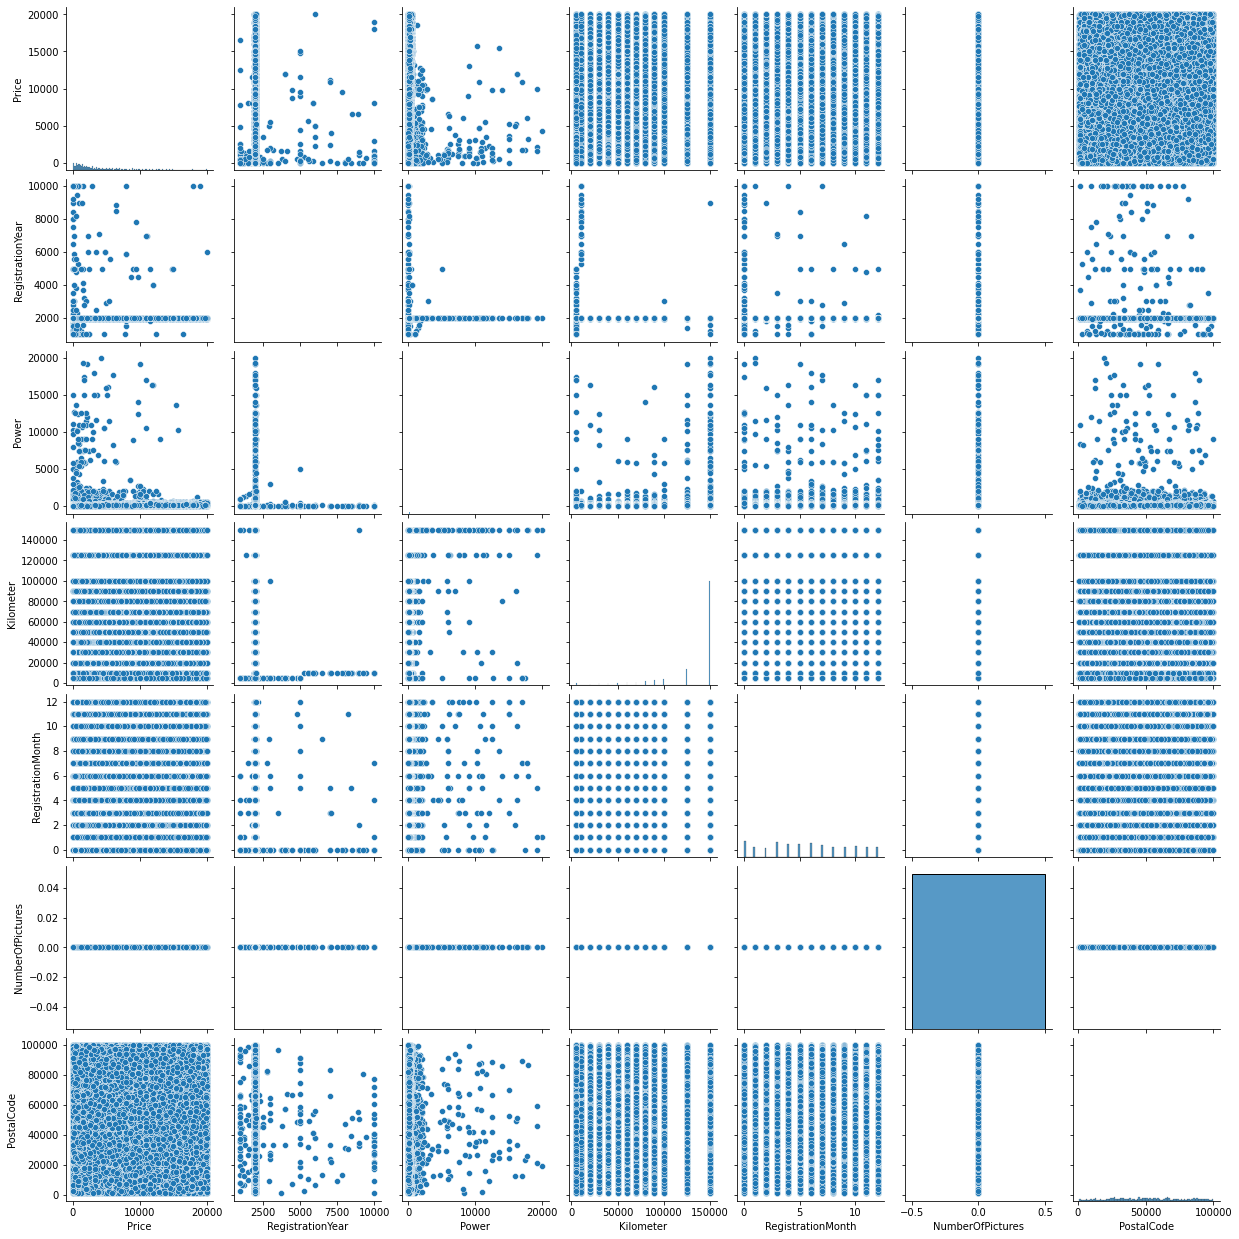

In [4]:
# построение диаграмм рассеяния по всем данным для датафрейма:

sns.pairplot(df);

In [5]:
# вывод первых строк датафрейма:

df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
# вывод последних строк датафрейма:

df.tail()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21


In [7]:
# проанализируем датафрейм с помощью метода describe():

df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Наблюдаются выбросы и экстремальные значения:

   - минимальная стоимость автомобиля - 0;
   - минимальный/максимальный год регистрации автомобиля - 1000/9999;
   - минимальная мощность/максимальная мощность двигателя - 0/20000;
   
Количество фотографий автомобиля 0 во всех объявлениях - удалим этот признак.

Можно выделить признаки, не влияющие на стоимость автомобиля:

   - почтовый индекс владельца анкеты (пользователя);
   - дата скачивания анкеты из базы;
   - дата создания анкеты;
   - месяц регистрации автомобиля - обычно смотрят на год.
   
В дальнейшем удалим неинформативные признаки.


In [8]:
# приведем наименования столбцов к стилю snake_case
# с использованием регулярного выражения:

df.columns = df.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]

/tmp/ipykernel_180/1036113465.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]


In [9]:
# вывод общей информации о датафрейме:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

In [10]:
# список не информативных признаков:
unnecessary_features = \
    ['number_of_pictures', 'postal_code', 'last_seen', 'registration_month', 'date_created']

# удалим не информативные признаки
df.drop(columns=unnecessary_features, axis=1 , inplace=True)


In [11]:
# проверка:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   date_crawled       354369 non-null  object
 1   price              354369 non-null  int64 
 2   vehicle_type       316879 non-null  object
 3   registration_year  354369 non-null  int64 
 4   gearbox            334536 non-null  object
 5   power              354369 non-null  int64 
 6   model              334664 non-null  object
 7   kilometer          354369 non-null  int64 
 8   fuel_type          321474 non-null  object
 9   brand              354369 non-null  object
 10  repaired           283215 non-null  object
dtypes: int64(4), object(7)
memory usage: 29.7+ MB


In [12]:
# поиск дубликатов:

df.duplicated().sum()

25

In [13]:
# удалим явные дубликаты:

df = df.drop_duplicates()


In [14]:
# проверка на дубликаты:

df.duplicated().sum()

0

In [15]:
# сброс индексов:

df.reset_index(drop=True , inplace=True )

In [16]:
# вывод общей информации:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354344 entries, 0 to 354343
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   date_crawled       354344 non-null  object
 1   price              354344 non-null  int64 
 2   vehicle_type       316854 non-null  object
 3   registration_year  354344 non-null  int64 
 4   gearbox            334511 non-null  object
 5   power              354344 non-null  int64 
 6   model              334639 non-null  object
 7   kilometer          354344 non-null  int64 
 8   fuel_type          321449 non-null  object
 9   brand              354344 non-null  object
 10  repaired           283190 non-null  object
dtypes: int64(4), object(7)
memory usage: 29.7+ MB


In [17]:
# вывод нескольких строк:

df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


Проанализируем годы выпуска автомобилей.

In [18]:
# уникальные значения признака registration_year:

df.registration_year.sort_values().unique()

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

Здесь сразу можно отметить аномальные значения: выпуски из далекого прошлого и будущего. Согласно Википедии, первым автомобилем считается автомобиль, выпущенный в 1885 году.

Приведем тип данных в столбце `date_crawled` к типу datetime.

In [19]:
# избавимся от значений времени и оставим только дату:

df['date_crawled'] = pd.to_datetime(df['date_crawled']).dt.date


In [20]:
# приведем к типу данных datetime:

df['date_crawled'] = pd.to_datetime(df['date_crawled'])

In [21]:
# проверка:

df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,2016-03-24,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,2016-03-24,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,2016-03-14,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,2016-03-17,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,2016-03-31,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


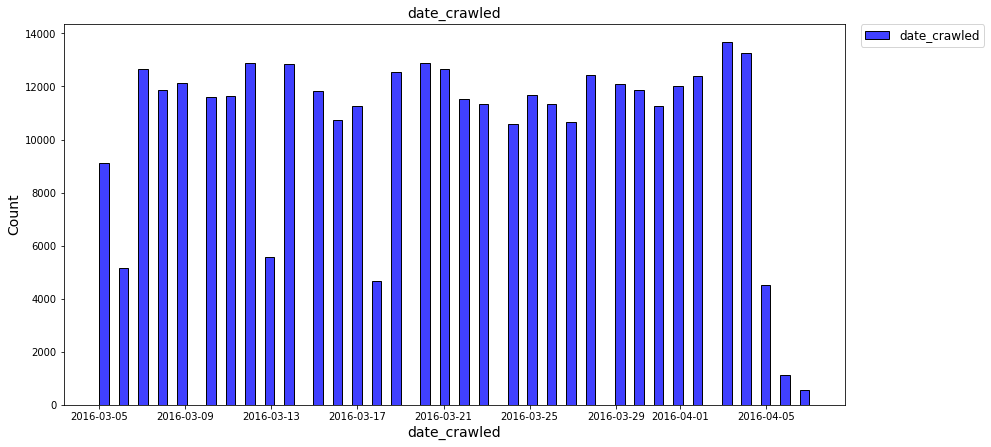

In [22]:
# histplot распределения признака date_crawled:

plt.figure(figsize=(14,7))
plt.rc('axes', titlesize=14) 
plt.rc('axes', labelsize=14) 
plt.rc('legend', fontsize=12) 

sns.histplot(df.date_crawled, label = 'date_crawled', color = 'b');

plt.title('date_crawled')
plt.legend(bbox_to_anchor= (1.02, 1), loc='upper left', borderaxespad = 0)
plt.show()

Даты скачивания анкет из базы варьируются с марта по апрель 2016 года.

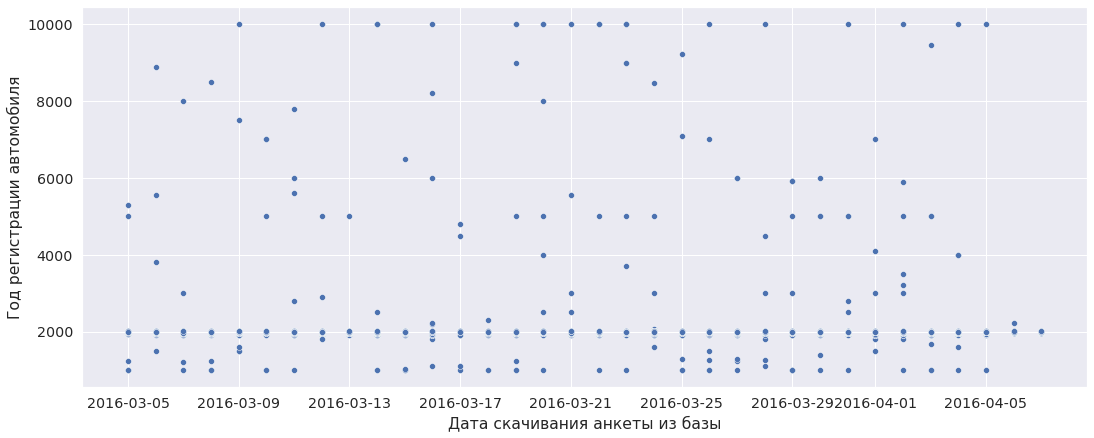

In [23]:
# взаимосвязь между годом регистрации автомобиля и датой выгрузки объявления:

plt.figure(figsize=(18,7))

sns.set(font_scale=1.3)
sns.scatterplot(
    x='date_crawled', 
    y='registration_year', 
    data=df)
plt.xlabel(
    'Дата скачивания анкеты из базы')
plt.ylabel(
    'Год регистрации автомобиля');

Снова видны аномальные значения - год регистрации автомобиля для некоторых объявлений намного превышает год скачивания анкеты из базы.

In [24]:
# уникальные значения признака registration_year:

df.registration_year.sort_values().unique()

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

In [25]:
# удаление объявлений с аномальными значениями года регистрации автомобиля:

df = df.query('registration_year >= 1910 and registration_year <=2019')

In [26]:
# удаление признака date_crawled:

df.drop(columns='date_crawled', axis=1 , inplace=True)

In [27]:
# сброс индексов:

df.reset_index(drop=True , inplace=True )

In [28]:
# проверка:

df.registration_year.sort_values().unique()

array([1910, 1915, 1919, 1920, 1923, 1925, 1927, 1928, 1929, 1930, 1931,
       1932, 1933, 1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943,
       1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954,
       1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965,
       1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976,
       1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987,
       1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998,
       1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])

Проанализируем датафрейм на наличие пропусков.

In [29]:
# поиск пропусков, в %:

df.isna().sum() / len(df) * 100

price                 0.000000
vehicle_type         10.536941
registration_year     0.000000
gearbox               5.560842
power                 0.000000
model                 5.542489
kilometer             0.000000
fuel_type             9.251693
brand                 0.000000
repaired             20.048677
dtype: float64

Проанализируем признаки vehicle_type. Выведем несколько строк с пропусками.

In [30]:
# пропуски в vehicle_type:

df[df['vehicle_type'].isna()].head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
16,300,NaN,2016,NaN,60,polo,150000,petrol,volkswagen,NaN
22,2900,NaN,2018,manual,90,meriva,150000,petrol,opel,no
26,5555,NaN,2017,manual,125,c4,125000,NaN,citroen,no
31,899,NaN,2016,manual,60,clio,150000,petrol,renault,NaN


In [31]:
# уникальные значения в vehicle_type:

df.vehicle_type.unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

Заменим `nan` на `other` в столбце `vehicle_type`.

In [32]:
df.vehicle_type = df.vehicle_type.fillna('other')

In [33]:
# проверка на пропуски в vehicle_type:

df.vehicle_type.isna().sum()

0

Проанализируем признаки `gearbox`. Выведем несколько строк с пропусками.

In [34]:
# пропуски в gearbox:

df[df['gearbox'].isna()].head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
15,450,small,1910,NaN,0,ka,5000,petrol,ford,NaN
16,300,other,2016,NaN,60,polo,150000,petrol,volkswagen,NaN
32,245,sedan,1994,NaN,0,golf,150000,petrol,volkswagen,no
37,1500,other,2016,NaN,0,kangoo,150000,gasoline,renault,no
40,0,other,1990,NaN,0,corsa,150000,petrol,opel,NaN


In [35]:
# уникальные значения в gearbox:

df.gearbox.unique()

array(['manual', 'auto', nan], dtype=object)

Заполним `nan` модой.

In [36]:
# заполнение nan модой:

df['gearbox'] = df['gearbox'].fillna(df['gearbox'].value_counts().index[0])

In [37]:
# проверка:

df.gearbox.unique()

array(['manual', 'auto'], dtype=object)

In [38]:
# проверка:

df.isna().sum()

price                    0
vehicle_type             0
registration_year        0
gearbox                  0
power                    0
model                19630
kilometer                0
fuel_type            32767
brand                    0
repaired             71007
dtype: int64

Теперь проанализируем признак `model`.

In [39]:
# пропуски в model:

df[df['model'].isna()].head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
59,1,suv,1994,manual,286,NaN,150000,NaN,sonstige_autos,NaN
81,350,small,1997,manual,54,NaN,150000,NaN,fiat,yes
115,0,small,1999,manual,0,NaN,5000,petrol,volkswagen,NaN
135,1450,sedan,1992,manual,136,NaN,150000,NaN,audi,no


In [40]:
# уникальные значения признака model:

df.model.unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

Попробуем найти тип модели `other`.

In [41]:
df[df['model'] == 'other'].head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
24,500,sedan,1990,manual,118,other,150000,petrol,mercedes_benz,yes
38,11900,other,2002,manual,129,other,150000,gasoline,volkswagen,no
39,1500,bus,1984,manual,70,other,150000,gasoline,mercedes_benz,no
52,1400,other,2016,manual,55,other,5000,NaN,hyundai,NaN


Действительно такая модель присутствует. Выполним замену `nan` у признака `model` на значение `other`.

In [42]:
df.model = df.model.fillna('other')

In [43]:
# проверка:

df.isna().sum()

price                    0
vehicle_type             0
registration_year        0
gearbox                  0
power                    0
model                    0
kilometer                0
fuel_type            32767
brand                    0
repaired             71007
dtype: int64

Перейдем к заполнению пропусков у признака `fuel_type`. Выведем строки с пропусками.

In [44]:
df[df.fuel_type.isna()].head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
9,999,small,1998,manual,101,golf,150000,NaN,volkswagen,NaN
13,2500,wagon,2004,manual,131,passat,150000,NaN,volkswagen,no
26,5555,other,2017,manual,125,c4,125000,NaN,citroen,no
36,1600,other,1991,manual,75,kadett,70000,NaN,opel,NaN
41,7500,sedan,2002,auto,306,e_klasse,150000,NaN,mercedes_benz,NaN


In [45]:
# вывод уникальных значений:

df.fuel_type.unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Заменим nan в признаке `fuel_type` на `other`.

In [46]:
df.fuel_type = df.fuel_type.fillna('other')

In [47]:
# проверка:

df.isna().sum()

price                    0
vehicle_type             0
registration_year        0
gearbox                  0
power                    0
model                    0
kilometer                0
fuel_type                0
brand                    0
repaired             71007
dtype: int64

Перейдем к признаку `repaired`. Выведем несколько строк с пропусками.

In [48]:
df[df.repaired.isna()].head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,other,1993,manual,0,golf,150000,petrol,volkswagen,NaN
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,NaN
9,999,small,1998,manual,101,golf,150000,other,volkswagen,NaN
12,999,wagon,1995,manual,115,passat,150000,petrol,volkswagen,NaN


In [49]:
# вывод уникальных значений:

df.repaired.unique()

array([nan, 'yes', 'no'], dtype=object)

Предположим, что `nan` - это отсутствие наличия ремонта. Заменим `nan` на `no`.

In [50]:
df.repaired = df.repaired.fillna('no')

In [51]:
# проверка

df.repaired.unique()

array(['no', 'yes'], dtype=object)

In [52]:
# проверка на пропуски:

df.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

Признак `repaired` по сути категориальный, принимает два значения: `yes` и `no`. Заменим `yes` на `1`, а `no` на `0`.

In [53]:
# замена значений у признака repaired:

df['repaired'] = df['repaired'].replace ('yes', 1)
df['repaired'] = df['repaired'].replace ('no', 0)


In [54]:
df.repaired.unique()

array([0, 1])

In [55]:
# вывод общей информации:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354173 entries, 0 to 354172
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354173 non-null  int64 
 1   vehicle_type       354173 non-null  object
 2   registration_year  354173 non-null  int64 
 3   gearbox            354173 non-null  object
 4   power              354173 non-null  int64 
 5   model              354173 non-null  object
 6   kilometer          354173 non-null  int64 
 7   fuel_type          354173 non-null  object
 8   brand              354173 non-null  object
 9   repaired           354173 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 27.0+ MB


Проанализируем признак `power`. Ранее обнаружено было наличие аномальных значений.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


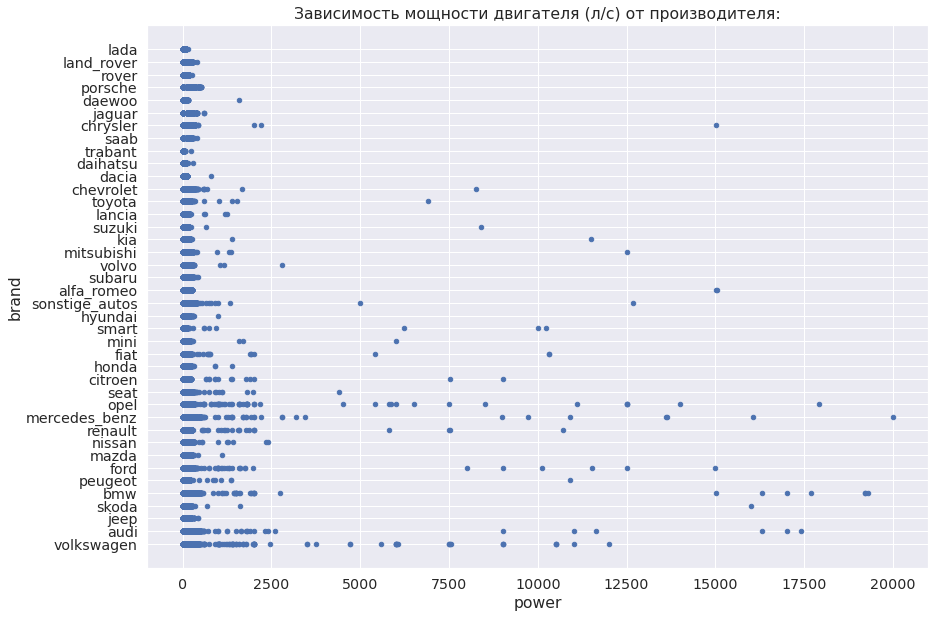

In [56]:
# график зависимосити мощности двигателя от производителя:

df.plot(x='power', y='brand', kind='scatter', \
    grid=True, figsize=(14, 10), \
    title='Зависимость мощности двигателя (л/с) от производителя:');

Не понятная шкала принимаемых значений. В среднем у автомобиля не более 200 л/с. У автомобилей с большим объемом двигателя не более 500 л/с. У спорткаров 1400 л/с. Тут наблюдаем максимум в 20 000 л/с. И также много объявлений до 2 500 л/с. Возможно имели ввиду объем двигателя или обороты? 

Посмотрим на объявления, где мотор более 500 л/с.

In [57]:
df.query('power > 500')['brand'].unique()

array(['toyota', 'opel', 'smart', 'mitsubishi', 'chevrolet', 'fiat',
       'volkswagen', 'honda', 'lancia', 'ford', 'jaguar', 'renault',
       'bmw', 'seat', 'nissan', 'mercedes_benz', 'porsche', 'citroen',
       'audi', 'skoda', 'volvo', 'sonstige_autos', 'peugeot', 'kia',
       'chrysler', 'mazda', 'suzuki', 'mini', 'alfa_romeo', 'daewoo',
       'hyundai', 'dacia'], dtype=object)

Посмотрим на объявления `alfa_romeo`.

In [58]:
df.query('power > 500 and brand == "alfa_romeo"')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
148388,3650,small,2002,auto,15020,147,125000,petrol,alfa_romeo,0
205702,3150,coupe,2007,manual,15033,other,5000,gasoline,alfa_romeo,0


Это точно не спорткары. Выведем процентное соотношение автомобилей, у которых более 600 л/с

In [59]:
print(round((len(df.query('power > 600')) * 100) / len(df), 2), '%')

0.11 %


Совсем небольшой объем таких объявлений. Посмотрим на эти объявления.

In [60]:
df.query('power > 600')['brand'].unique()

array(['toyota', 'opel', 'smart', 'mitsubishi', 'chevrolet', 'fiat',
       'volkswagen', 'honda', 'lancia', 'ford', 'seat', 'bmw', 'nissan',
       'mercedes_benz', 'citroen', 'audi', 'skoda', 'volvo', 'peugeot',
       'sonstige_autos', 'kia', 'renault', 'chrysler', 'mazda', 'suzuki',
       'mini', 'alfa_romeo', 'daewoo', 'hyundai', 'dacia'], dtype=object)

Спорткары явно отсутствуют. Посмотрим на корреляционную зависимость между л/с и стоимостью автомобилей.


In [61]:
# зависимость между стоимостью автомобилей и их мощности:

df[['power', 'price']].corr()

,power,price
power,1.000000,0.159305
price,0.159305,1.000000


Зависимость отсутствует, поэтому удалим объявления где мощность двигателя более 600 л/с. К тому же таких объявлений всего 0.1% от общего числа объявлений.

In [62]:
# удаление объявлений, где мощность двигателя более 600 л/с:

df = df.query('power <= 600')

In [63]:
# сброс индексов:

df.reset_index(drop=True , inplace=True )

Рассмотрим объявления с объемами двигателя равным нулю.

In [64]:
df.query('power == 0')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,other,1993,manual,0,golf,150000,petrol,volkswagen,0
15,450,small,1910,manual,0,ka,5000,petrol,ford,0
32,245,sedan,1994,manual,0,golf,150000,petrol,volkswagen,0
37,1500,other,2016,manual,0,kangoo,150000,gasoline,renault,0
40,0,other,1990,manual,0,corsa,150000,petrol,opel,0
...,...,...,...,...,...,...,...,...,...,...
353769,180,other,1995,manual,0,other,125000,petrol,opel,0
353777,2600,other,2005,auto,0,c_klasse,150000,other,mercedes_benz,0
353794,1150,bus,2000,manual,0,zafira,150000,petrol,opel,0
353795,0,other,2005,manual,0,colt,150000,petrol,mitsubishi,1


In [65]:
# %-ое кол-во объявлений с нулевым объемом двигателя:

print(round((len(df.query('power == 0')) * 100) / len(df), 2), '%')

11.33 %


Возможно есть предложения с послеаварийными машинами, без двигателей. Или не верно заполнили анкету.

Рассмотрим распределение объемов двигателя в анкетах с помощью гистограммы. Построим для объема двигателя менее 100 л/с.

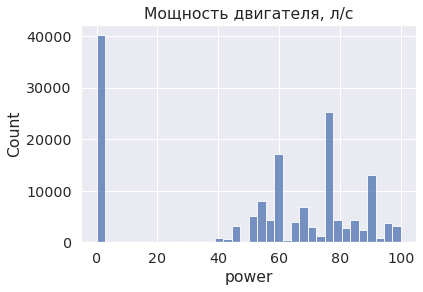

In [66]:
# гистограмма распределения объемов двигателя менее 100 л/с:

sns.histplot(df.query('power <= 100').power);
plt.title('Мощность двигателя, л/с')

plt.show()

Вычислим процентный объем объявлений с объемом двигателя менее 40 л/с.

In [67]:
# %-ое кол-во объявлений с кол-вом л/с менее 40:

print(round((len(df.query('power < 40')) * 100) / len(df), 2), '%')

11.74 %


Получили примерно такое же количество объявлений как и с нулевой мощностью двигателя. Удалим все объявления с количеством л/с менее 40. 

In [68]:
# удаление объявлений, где мощность двигателя менее 40 л/с:

df = df.query('power >= 40')

In [69]:
# сброс индексов:

df.reset_index(drop=True , inplace=True )

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312277 entries, 0 to 312276
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              312277 non-null  int64 
 1   vehicle_type       312277 non-null  object
 2   registration_year  312277 non-null  int64 
 3   gearbox            312277 non-null  object
 4   power              312277 non-null  int64 
 5   model              312277 non-null  object
 6   kilometer          312277 non-null  int64 
 7   fuel_type          312277 non-null  object
 8   brand              312277 non-null  object
 9   repaired           312277 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 23.8+ MB


Рассмотрим целевой признак со стоимостью автомобилей.

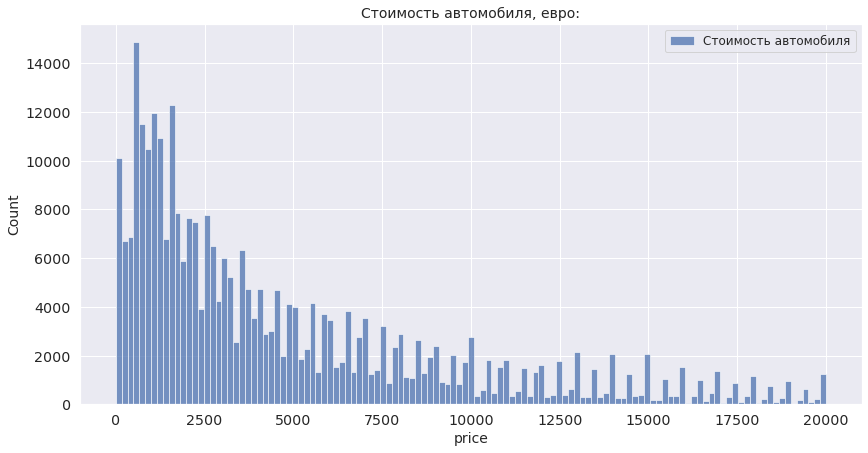

In [71]:
# histplot распределения целевого признака price:

plt.figure(figsize=(14,7))
plt.rc('axes', titlesize=14) 
plt.rc('axes', labelsize=14) 
plt.rc('legend', fontsize=12) 

sns.histplot(df.price, label = 'Стоимость автомобиля');

plt.title('Стоимость автомобиля, евро:')
plt.legend()
plt.show()

Много объявлений с нулевой стоимостью. Подсчитаем кол-во таких объявлений.

In [72]:
# %-ое кол-во объявлений с нулевой стоимостью автомобилей:

print(round((len(df.query('price == 0')) * 100) / len(df), 2), '%')

2.18 %


Таких объявлений совсем не много. Удалим их.

In [73]:
df = df[df['price'] != 0]

In [74]:
# сброс индексов:

df.reset_index(drop=True , inplace=True)

Рассмотрим объявления с околонулевой ценой.

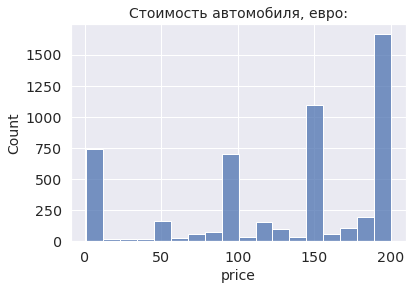

In [75]:
# гистограмма распределения объявлений со стоимостью двигателя менее 200 евро:

sns.histplot(df.query('price <= 200').price)
plt.title('Стоимость автомобиля, евро:')

plt.show();

Оставим объявления со стоимостью машин более 100 евро включительно.

In [76]:
df = df[df['price'] >= 100]

In [77]:
# сброс индексов:

df.reset_index(drop=True , inplace=True)

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304256 entries, 0 to 304255
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              304256 non-null  int64 
 1   vehicle_type       304256 non-null  object
 2   registration_year  304256 non-null  int64 
 3   gearbox            304256 non-null  object
 4   power              304256 non-null  int64 
 5   model              304256 non-null  object
 6   kilometer          304256 non-null  int64 
 7   fuel_type          304256 non-null  object
 8   brand              304256 non-null  object
 9   repaired           304256 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 23.2+ MB


**Вывод**

Изучили исходные данные. Исходный датасет состоит из `16` признаков и `354369` объектов. 

В исходном датасете присутствуют категориальные и числовые признаки. Также присутствуют неинформативные признаки, от которых избавились в процессе предобработки данных.

В исходных данных присутствуют пропуски и аномальные значения. Пропуски заменили на наиболее часто-встречающиеся значения, либо определили в группу `other`. Аномальные значения удалили.

После проведения предобработки датасет состоит из `10` признаков и `304256` объектов.

## Подготовка выборок для обучения моделей

[Назад к содержанию](#Содержание)

Создадим переменные для признаков и целевого признака:

  - в качестве целевого признака `target` будем использовать признак `price`;
  - в качестве признаков `features` будем использовать все признаки, за исключением целевого.

Пропишем переменные:

In [79]:
# признаки: 
features = df.drop('price', axis=1)

# целевой признак:
target = df['price']

Поскольку у нас отсутствует отдельный датасет для тестирования модели, разобьем исходный датафрейм на обучающую, валидационную и тестовую выборки в соотношении 3:1:1:

  - 60% под обучающую выборку;
  - 20% под валидационную выборку;
  - 20% под тестовую выборку.

Разделение выборок выполним поэтапно: сперва выделим 60% под обучающую выборку, оставшиеся 40% поделим поровну между валидационной и тестовой выборками.

In [80]:
# выделим 60% под обучающую выборку:

features_train, features_valid_test, target_train, target_valid_test = \
    train_test_split(features, target, test_size = 0.4, random_state = RANDOM_STATE)

In [81]:
# проверим количество получившихся объектов:

print('features_train:', features_train.shape)
print('features_valid_test:', features_valid_test.shape)
print('target_train:', target_train.shape)
print('target_valid_test:', target_valid_test.shape)

features_train: (182553, 9)
features_valid_test: (121703, 9)
target_train: (182553,)
target_valid_test: (121703,)


Далее оставшиеся 40% разобъем поровну между валидационной и тестовой выборками.

In [82]:
# выделим по 20% под валидационную и тестовую выборки:

features_valid, features_test, target_valid, target_test = \
    train_test_split(features_valid_test, target_valid_test, \
    test_size = 0.5, random_state = RANDOM_STATE) 
                                                    

In [83]:
# проверим количество получившихся объектов:

print('features_valid:', features_valid.shape)
print('features_test:', features_test.shape)
print('target_valid:', target_valid.shape)
print('target_test:', target_test.shape)


features_valid: (60851, 9)
features_test: (60852, 9)
target_valid: (60851,)
target_test: (60852,)


Далее планируем обучать несколько типов моделей: `CatBoostRegressor`, `LGBMRegressor` и `RandomForestRegressor`.

   - Для `CatBoostRegressor` преобразование данных не требуется - будем использовать существующие признаки без изменений. Для `Catboost` укажем категориальные признаки в явном виде.
   - Для `LGBMRegressor` и `RandomForestRegressor` применим преобразование категориальных признаков методом `OE` и числовых признаков с помощью `StandardScaler`.

Что бы в дальнейшем отличить преобразованные признаки от не преобразованных, введем соответствующие переменные.

In [84]:
# выборки с преобразованными признаками:

features_train_transform = features_train.copy()
features_valid_transform = features_valid.copy()
features_test_transform = features_test.copy()

In [85]:
# список числовых признаков:

num_features = ['registration_year', 'power', 'kilometer']

In [86]:
# список категориальных признаков:

cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']


In [87]:
# сделаем объект типа OrdinalEncoder
# настроим кодировщик таким образом:
# если попадутся категории в тестовой выборке, которые отсутствовали
# в обучающей при настройке кодировщика,
# кодировщик закодирует значением -1

ordinal_encoder = OrdinalEncoder(
                    handle_unknown = 'use_encoded_value',
                    unknown_value = -1)


Далее произведем кодирование категориальных признаков.

In [88]:
# настройка кодировщика на обучающей выборке:

ordinal_encoder.fit(features_train_transform[cat_features])

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [89]:
# преобразование обучающей, валидационной и тестовой выборок функцией transform():

features_train_transform[cat_features] = ordinal_encoder.transform(features_train_transform[cat_features])
features_valid_transform[cat_features] = ordinal_encoder.transform(features_valid_transform[cat_features])
features_test_transform[cat_features] = ordinal_encoder.transform(features_test_transform[cat_features])


In [90]:
# проверка на преобразование категориальных признаков
# в обучающей выборке:

features_train_transform.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
12436,1.0,1998,1.0,150,116.0,150000,6.0,38.0,0.0
117509,5.0,2001,1.0,75,83.0,150000,6.0,24.0,0.0
67660,5.0,2014,1.0,68,8.0,80000,2.0,25.0,0.0
192637,4.0,1997,1.0,75,116.0,5000,6.0,38.0,0.0
243214,6.0,2005,1.0,140,208.0,150000,2.0,15.0,0.0


In [91]:
# проверка на размерность:

features_train_transform.shape

(182553, 9)

In [92]:
# проверка на преобразование категориальных признаков
# в валидационной выборке:

features_valid_transform.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
260762,1.0,2006,1.0,116,80.0,80000,6.0,21.0,0.0
254641,0.0,2003,1.0,136,221.0,150000,2.0,38.0,0.0
201547,7.0,2012,0.0,140,163.0,150000,2.0,31.0,0.0
279638,2.0,1998,1.0,136,63.0,150000,6.0,24.0,1.0
13981,5.0,2006,1.0,75,75.0,80000,6.0,27.0,0.0


In [93]:
# проверка на размерность:

features_valid_transform.shape

(60851, 9)

In [94]:
# проверка на преобразование категориальных признаков
# в тестовой выборке:

features_test_transform.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
123829,5.0,2000,1.0,58,226.0,150000,6.0,27.0,0.0
115477,5.0,2006,1.0,60,102.0,80000,6.0,10.0,0.0
131782,5.0,2006,1.0,69,244.0,125000,6.0,36.0,1.0
222906,4.0,2000,1.0,105,11.0,150000,6.0,2.0,0.0
144312,3.0,2017,1.0,64,173.0,150000,6.0,38.0,0.0


In [95]:
# проверка на размерность:

features_test_transform.shape

(60852, 9)

Размерность выборок совпадает до преобразования. Получившиеся выборки соответствуют нашим ожиданиям. 

Далее приведем численные признаки к одному масштабу с помощью `StandardScaler`.

In [96]:
# создаем объект структуры StandardScaler():
scaler = StandardScaler()

# настройка обучающих данных:
scaler.fit(features_train_transform[num_features])

# преобразование обучающей, валидационной и тестовой выборок функцией transform():
features_train_transform[num_features] = scaler.transform(features_train_transform[num_features])
features_valid_transform[num_features] = scaler.transform(features_valid_transform[num_features])
features_test_transform[num_features] = scaler.transform(features_test_transform[num_features])


Посмотрим на результат масштабирования.

In [97]:
features_train_transform.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
12436,1.0,-0.793551,1.0,0.550572,116.0,0.584403,6.0,38.0,0.0
117509,5.0,-0.351812,1.0,-0.853489,83.0,0.584403,6.0,24.0,0.0
67660,5.0,1.562392,1.0,-0.984534,8.0,-1.335889,2.0,25.0,0.0
192637,4.0,-0.940798,1.0,-0.853489,116.0,-3.393345,6.0,38.0,0.0
243214,6.0,0.237174,1.0,0.363364,208.0,0.584403,2.0,15.0,0.0


In [98]:
features_valid_transform.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
260762,1.0,0.384420,1.0,-0.085935,80.0,-1.335889,6.0,21.0,0.0
254641,0.0,-0.057319,1.0,0.288481,221.0,0.584403,2.0,38.0,0.0
201547,7.0,1.267899,0.0,0.363364,163.0,0.584403,2.0,31.0,0.0
279638,2.0,-0.793551,1.0,0.288481,63.0,0.584403,6.0,24.0,1.0
13981,5.0,0.384420,1.0,-0.853489,75.0,-1.335889,6.0,27.0,0.0


In [99]:
features_test_transform.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
123829,5.0,-0.499059,1.0,-1.171742,226.0,0.584403,6.0,27.0,0.0
115477,5.0,0.384420,1.0,-1.134301,102.0,-1.335889,6.0,10.0,0.0
131782,5.0,0.384420,1.0,-0.965814,244.0,-0.101415,6.0,36.0,1.0
222906,4.0,-0.499059,1.0,-0.291864,11.0,0.584403,6.0,2.0,0.0
144312,3.0,2.004131,1.0,-1.059418,173.0,0.584403,6.0,38.0,0.0


Выборки для `LGBM` и `RandomForestRegressor` готовы. 

## Обучение моделей

[Назад к содержанию](#Содержание)

Перед нами стоит задача регрессии - необходимо предсказать стоимость автомобиля по признакам. Для решения можно применить следующие методы обучения модели:

  - градиентный бустинг с помощью библиотеки `CatBoost`;
  - градиентный бустинг с помощью библиотеки `LightGBM`
  - случайный лес в регрессии.

Создадим переменные для хранения метрик качества обученных моделей.

In [100]:
# список с наименованиями обученных моделей:
models = []

# список для хранения времени поиска оптимальных
# гиперпараметров модели с помощью RandomizedSearchCV:
search_optimal_params_time = []

# список для хранения времени обучения модели на трейне:
training_time = []

# список для хранения времени предсказания
# на валидационной выборке:
prediction_time = []

# список для хранения RMSE на трейне:
rmse_train = []

# список для хранения RMSE на валидации:
rmse_valid = []

Сделаем функцию `get_importances` по выводу значимости признаков при обучении. Функция на вход будет принимать переменную, хранящую информацию о значимости признаков, выборку, на которой обучали модель и наименование модели, а на выходе будет выводить таблицу со значениями значимости признаков и строить наглядный график. Также функция будет сохранять качественные метрики в созданные переменные со списками качества обученных моделей.

In [101]:
def get_importances(model_importances, model_features_train, model_name):
    feature_list = list(model_features_train.columns)   
    feature_results = pd.DataFrame({
        'feature': feature_list,
        'importance': model_importances
    })  
    # Show the top most important: 
    feature_results = feature_results.sort_values( \
        'importance',ascending = False).reset_index(drop=True)  
    display(feature_results)
    print()

    importances = pd.Series(model_importances, index=feature_list)
    importances = importances.sort_values(ascending=False)
  
    figure, ax = plt.subplots()
    importances.plot.bar(yerr=model_importances, ax=ax)
    ax.set_title(f"Значимость признаков у {model_name}:")
    ax.set_ylabel("Вектор 'важностей'\nпризнаков")
    
    return plt.show();
    

Подбирать оптимальные гиперпараметры для моделей будем с помощью `RandomizedSearchCV`. В отличие от `GridSearchCV` `RandomizedSearchCV` позволит сократить время на обучение, но возможно немного "просядут" метрики качества.

Для поиска оптимальных гиперпараметров моделей с помощью `RandomizedSearchCV` разработаем функцию `search_params`. На вход функция будет принимать модель, список параметров для поиска и признаки для обучения. На выходе функция будет возвращать обученную модель с найденными оптимальными гиперпараметрами, оптимальные гиперпараметров модели, значение ошибки `RMSE` модели на обучающей выборке и время поиска оптимальных гиперпараметров.

In [102]:
# функция для поиска оптимальных параметров:

def search_params(
                model,
                model_name,
                params,
                features_for_learning,
                target_for_learning):

    # контроль времени на поиск оптимальных гиперпараметров:
    start_time = time.time()
  
    # рандомизированный поиск оптимальных параметров:
    model_random_search = RandomizedSearchCV(
            model,
            params, 
            cv = 5,
            scoring = 'neg_root_mean_squared_error',
            n_iter = 5,
            n_jobs = -1,
            verbose = 0)
    
    # обучение модели с помощью кросс-валидации на обучающей выборке:
    model_random_search.fit(features_for_learning, target_for_learning)
    
    # вычисление времени поиска оптимальных гиперпараметров:
    random_search_time = time.time() - start_time
    # перевод времени в формат Ч:М:СЕК:
    search_time = str(datetime.timedelta(seconds=random_search_time))
        
    # вывод лучших параметров, найденных после RandomizedSearchCV:
    best_params = model_random_search.best_params_
    print('Наилучшее гиперпараметры:', best_params)
    model_RMSE = model_random_search.best_score_ * -1
    print('Наилучшее RMSE на тренировочной выборке:', model_RMSE)
    print('Время поиска оптимальных гиперпараметров с RandomizedSearchCV:', 
          search_time, '(Ч:М:СЕК)')
    
    # сохранение результатов:
    
    # наименование модели:
    models.append(model_name)
    
    # время поиска оптимальных гиперпараметров с RandomizedSearchCV:
    search_optimal_params_time.append(search_time)
    
    # RMSE на трейне:
    rmse_train.append(model_RMSE)

    return model_random_search, best_params, model_RMSE, search_time

Для обучения моделей с найденными оптимальными гиперпараметрами создадим функцию `model`. На вход функция будет получать класс модели с оптимальными гиперпараметрами и выборки для обучения и валидации. Функция будет выполнять:

   - обучение модели на тренировочной выборке и подсчитывать время, потраченное на обучение модели;
   - предсказания модели на валидационной выборке и подсчитывать время на предсказания;
   - вычислять `RMSE` на валидационной выборке;
   - сохранять полученные результаты;
   - возвращать:
       - обученную модель с оптимальными гиперпараметрами,
       - время, потраченное на обучение на тренировочной выборке,
       - время, потраченное на предсказания на валидационной выборке,
       - `RMSE` на валидационной выборке.

In [103]:
def model(
        model,
        features_for_learning,
        target_for_learning,
        features_for_valid,
        target_for_valid):

    # создание модели с оптимальными гиперпараметрами:
    model_optimal = model

    # контроль времени на обучение модели с оптимальными гиперпараметрами:
    start_time = time.time()

    # обучение модели на тренировочной выборке:
    model_optimal.fit(features_for_learning, target_for_learning)

    # вычисление времени на обучение модели:
    model_optimal_time = time.time() - start_time
    # перевод времени в формат Ч:М:СЕК:
    model_optimal_time_format = str(datetime.timedelta(seconds=model_optimal_time))
    print('Время обучения модели с оптимальными гиперпараметрами, Ч:М:СЕК', model_optimal_time_format)
    
    # контроль времени на предсказания на валидационной выборке:
    start_time = time.time()

    # предсказания модели на валидационой выборке:
    model_predict = model_optimal.predict(features_for_valid)

    # вычисление времени на предсказания:
    model_predict_time = time.time() - start_time
    print('Время предсказания на валидационной выборке, сек', model_predict_time)
    
    # RMSE на валидационной выборке:
    rmse = np.sqrt(mean_squared_error(target_for_valid, model_predict))
    print('Среднеквадратичная ошибка RMSE на валидационной выборке:', rmse)
    
    # сохранение результатов:
    
    # время обучения модели на трейне:
    training_time.append(model_optimal_time_format)
    
    # время предсказания на валидационной выборке:
    prediction_time.append(model_predict_time)
    
    # RMSE на валидации:
    rmse_valid.append(rmse)
    
    return model_optimal, model_optimal_time_format, model_predict_time, rmse

### Градиентный бустинг с помощью `CatBoost`

[Назад к содержанию](#Содержание)

Обучим модель с помощью `CatBoostRegressor`. Сперва определим модель с гиперпараметрами и найдём оптимальные с помощью созданной функции `search_params`.

In [104]:
# определяем параметры для CatBoostRegressor:
cat_params = {
            'learning_rate': [0.03, 0.1, 0.5],
            'depth': [4, 6, 8, 10],
            'l2_leaf_reg': [1, 2, 3, 4],  
}

# создаем объект класса CatBoostRegressor:
cat_model = CatBoostRegressor(
                    cat_features=cat_features,
                    random_state=RANDOM_STATE,
                    verbose=0,
)

In [105]:
%%time

# поиск оптимальных гиперпараметров
# с помощью функции random_search:

cat, cat_params, cat_rmse, cat_time = search_params(
                                                cat_model,
                                                'CatBoostRegressor',
                                                cat_params,
                                                features_train,
                                                target_train
                                                )

Наилучшее гиперпараметры: {'learning_rate': 0.03, 'l2_leaf_reg': 1, 'depth': 10}
Наилучшее RMSE на тренировочной выборке: 1584.8068293209988
Время поиска оптимальных гиперпараметров с RandomizedSearchCV: 1:13:44.286715 (Ч:М:СЕК)
CPU times: user 1h 12min 55s, sys: 15.8 s, total: 1h 13min 11s
Wall time: 1h 13min 44s


In [106]:
# фиксация значимых признаков:

cat_features_importances = cat.best_estimator_.feature_importances_

,feature,importance
0,registration_year,31.544955
1,power,20.985632
2,vehicle_type,12.445219
3,brand,12.356491
4,kilometer,11.181725
5,model,5.212385
6,fuel_type,3.214540
7,repaired,2.174005
8,gearbox,0.885048


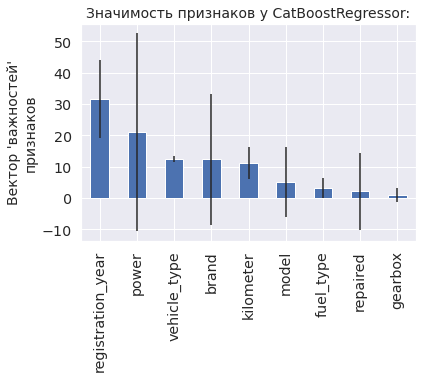

In [107]:
# вывод важности признаков для модели CatBoostRegressor:

get_importances(cat_features_importances, features_train, "CatBoostRegressor")

Самые значимые признаки - это `год регистрации автомобиля`, `мощность` и `тип кузова`. 

Теперь заново обучим модель на тренировочных данных с найденными оптимальными гиперпараметрами. Воспользуемся созданной функцией `model`.

In [108]:
# объект класса CatBoostRegressor с оптимальными гиперпараметрами:

cat_model_optimal = CatBoostRegressor(
                          cat_features=cat_features,
                          random_state=RANDOM_STATE,
                          verbose=0,
                          **cat_params
)

In [109]:
%%time

# обучение модели с оптимальными гиперпараметрами:
cat_optimal, cat_optimal_time, cat_optimal_predict_time, cat_optimal_rmse = model(
                                                                                cat_model_optimal,
                                                                                features_train,
                                                                                target_train,
                                                                                features_valid,
                                                                                target_valid
)

Время обучения модели с оптимальными гиперпараметрами, Ч:М:СЕК 0:04:42.890666
Время предсказания на валидационной выборке, сек 0.707991361618042
Среднеквадратичная ошибка RMSE на валидационной выборке: 1568.101252981521
CPU times: user 4min 40s, sys: 760 ms, total: 4min 41s
Wall time: 4min 43s


Можно отметить положительную тенденцию при обучении: значение ошибки `RMSE` на валидационной выборке снизилось по сравнению с `RMSE` на обучающей выборке. Это значит, что модель у нас не переобучилась.

### Градиентный бустинг с помощью `LightGBM`

[Назад к содержанию](#Содержание)

Обучим модель с помощью библиотеки `LightGBM`.

In [110]:
# определяем параметры LGBMRegressor:
lgbm_params = {
            'learning_rate': [0.03, 0.1, 0.5],
            'max_depth': [4, 6, 8],
            'reg_alpha': np.arange(0, 0.21, 0.05),  
}

# создаем объект класса LGBMRegressor:
lgbm_model = LGBMRegressor(
                    objective = "regression",
                    random_state=RANDOM_STATE
)

In [111]:
%%time

# поиск оптимальных гиперпараметров
# с помощью функции search_params:

lgbm, lgbm_params, lgbm_rmse, lgbm_time = search_params(
                                                    lgbm_model,
                                                    'LGBMRegressor',
                                                    lgbm_params, 
                                                    features_train_transform, # преобразованные признаки
                                                    target_train)

Наилучшее гиперпараметры: {'reg_alpha': 0.15000000000000002, 'max_depth': 8, 'learning_rate': 0.5}
Наилучшее RMSE на тренировочной выборке: 1641.5020060979853
Время поиска оптимальных гиперпараметров с RandomizedSearchCV: 0:02:18.911351 (Ч:М:СЕК)
CPU times: user 2min 16s, sys: 728 ms, total: 2min 16s
Wall time: 2min 18s


In [112]:
# фиксация значимых признаков:

lgbm_features_importances = lgbm.best_estimator_.feature_importances_

,feature,importance
0,power,781
1,registration_year,673
2,model,433
3,brand,356
4,kilometer,303
5,vehicle_type,229
6,fuel_type,97
7,gearbox,67
8,repaired,45


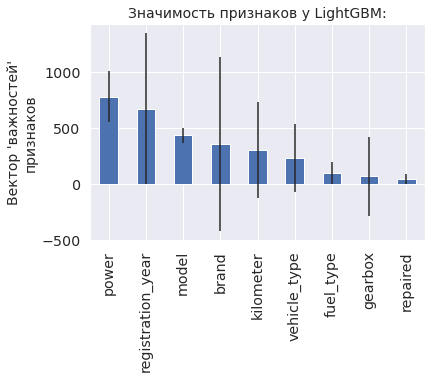

In [113]:
# вывод важности признаков для модели LightGBM:

get_importances(lgbm_features_importances, features_train_transform, "LightGBM")

Самые значимые признаки - это `мощность`, `год регистрации автомобиля` и `модель`. Важность признаков несколько отличается от `CatBoostRegressor`.

Теперь заново обучим модель на тренировочных данных с найденными оптимальными гиперпараметрами. Воспользуемся созданной функцией `model`.

In [114]:
# объект класса LGBMRegressor с оптимальными гиперпараметрами:

lgbm_model_optimal = LGBMRegressor(
                    objective = "regression",
                    random_state=RANDOM_STATE,
                    **lgbm_params
)

In [115]:
%%time

# обучение модели с оптимальными гиперпараметрами:
lgbm_optimal, lgbm_optimal_time, lgbm_optimal_predict_time, lgbm_optimal_rmse = model(
                        lgbm_model_optimal,
                        features_train_transform,
                        target_train,
                        features_valid_transform,
                        target_valid
)

Время обучения модели с оптимальными гиперпараметрами, Ч:М:СЕК 0:00:02.896881
Время предсказания на валидационной выборке, сек 0.39461231231689453
Среднеквадратичная ошибка RMSE на валидационной выборке: 1631.9862122466375
CPU times: user 3.27 s, sys: 8.12 ms, total: 3.27 s
Wall time: 3.29 s


Также значение ошибки `RMSE` на валидационной выборке снизилось по сравнению с `RMSE` на обучающей выборке.

### Обучение модели с помощью `RandomForestRegressor`

[Назад к содержанию](#Содержание)

Обучим модель с помощью `RandomForestRegressor`. Для обучения будем использовать преобразованные выборки.

In [116]:
# определяем параметры RandomForestRegressor:
rfr_params = {
            'max_depth': [3, 5, 10, 15, 20],
            'n_estimators': [10, 25, 50, 75],
            'min_samples_leaf': [2, 5, 7, 10],
            'min_samples_split': [2, 5, 7, 10]  
}

# создаем объект класса RandomForestRegressor:
rfr_model = RandomForestRegressor(random_state=RANDOM_STATE)

In [117]:
%%time

# поиск оптимальных гиперпараметров
# с помощью функции search_params:

rfr, rfr_params, rfr_rmse, rfr_time = search_params(
                                                    rfr_model,
                                                    'RandomForestRegressor',
                                                    rfr_params, 
                                                    features_train_transform, # преобразованные признаки
                                                    target_train)

Наилучшее гиперпараметры: {'n_estimators': 25, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 15}
Наилучшее RMSE на тренировочной выборке: 1674.195167261625
Время поиска оптимальных гиперпараметров с RandomizedSearchCV: 0:02:42.389457 (Ч:М:СЕК)
CPU times: user 2min 41s, sys: 103 ms, total: 2min 41s
Wall time: 2min 42s


In [118]:
# фиксация значимых признаков:

rfr_features_importances = rfr.best_estimator_.feature_importances_

,feature,importance
0,registration_year,0.509807
1,power,0.301475
2,kilometer,0.084296
3,brand,0.031595
4,vehicle_type,0.027341
5,model,0.025578
6,repaired,0.009814
7,fuel_type,0.006572
8,gearbox,0.003522


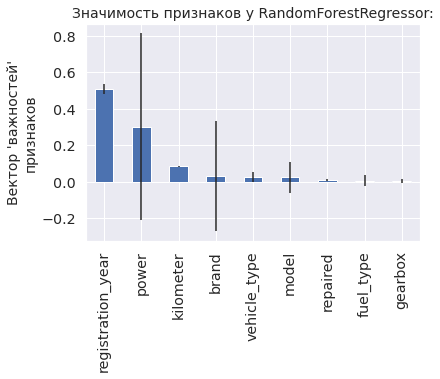

In [119]:
# вывод важности признаков для модели RandomForestRegressor:

get_importances(rfr_features_importances, features_train_transform, "RandomForestRegressor")

Схожие значимые признаки - `год регистрации автомобиля`, `мощность` и `пробег`.

Теперь заново обучим модель на тренировочных данных с найденными оптимальными гиперпараметрами. Воспользуемся созданной функцией `model`.

In [120]:
# объект класса RandomForestRegressor с оптимальными гиперпараметрами:

rfr_model_optimal = RandomForestRegressor(
                                        random_state=RANDOM_STATE,
                                        **rfr_params
)

In [121]:
%%time

# обучение модели с оптимальными гиперпараметрами:
rfr_optimal, rfr_optimal_time, rfr_optimal_predict_time, rfr_optimal_rmse = model(
                                                                                    rfr_model_optimal,
                                                                                    features_train_transform,
                                                                                    target_train,
                                                                                    features_valid_transform,
                                                                                    target_valid
)

Время обучения модели с оптимальными гиперпараметрами, Ч:М:СЕК 0:00:06.604183
Время предсказания на валидационной выборке, сек 0.21290302276611328
Среднеквадратичная ошибка RMSE на валидационной выборке: 1647.9342699449483
CPU times: user 6.81 s, sys: 0 ns, total: 6.81 s
Wall time: 6.82 s


Также значение ошибки `RMSE` на валидационной выборке снизилось по сравнению с `RMSE` на обучающей выборке.

## Анализ моделей

[Назад к содержанию](#Содержание)

Выведем метрики, полученные после обучения моделей. И выберем наилучшую модель.

In [122]:
# таблица с полученными результатами:
results = (pd.DataFrame({
                        'Модель':models,
                        'Время поиска оптим. параметров, ч:м:сек':search_optimal_params_time,
                        'Время обучения на трейне, ч:м:сек':training_time,
                        'Время предсказания на валидации, сек':prediction_time,
                        'RMSE на трейне':rmse_train,
                        'RMSE на валидации':rmse_valid,
                        }).sort_values(by='RMSE на валидации', ascending=True).
                              reset_index(drop=True))

# вывод результатов:
results

,Модель,"Время поиска оптим. параметров, ч:м:сек","Время обучения на трейне, ч:м:сек","Время предсказания на валидации, сек",RMSE на трейне,RMSE на валидации
0,CatBoostRegressor,1:13:44.286715,0:04:42.890666,0.707991,1584.806829,1568.101253
1,LGBMRegressor,0:02:18.911351,0:00:02.896881,0.394612,1641.502006,1631.986212
2,RandomForestRegressor,0:02:42.389457,0:00:06.604183,0.212903,1674.195167,1647.934270


На основе таблицы, можно сделать следующие заключения.

   1. Наименьшая `RMSE`-ошибка у модели, обученной с помощью `CatBoostRegressor`.
   2. У `CatBoostRegressor` самое длительное время поиска оптимальных гиперпараметров, время обучения на трейне и время предсказания на валидации. 
   
Напомним, что основные критерии заказчика к модели - это качество предсказания, скорость предсказания и время обучения.

Поскольку `RMSE` у `CatBoostRegressor` значительно меньше по сранению с другими моделями, то хотелось бы `CatBoostRegressor` использовать в качесте наилучшей модели.

Попытаемся защитить `CatBoostRegressor`. Поиск оптимальных гиперпараметров выполняется не так часто, поэтому этим параметром можно пренебречь. Время обучения также выполняется не часто. Время предсказания `CatBoostRegressor` на валидации дольше на 2-3 секунды по сравнению с другими моделями. Модель обучается и предсказывает по времени дольше, но и более качественно. Поэтому если заказчика устраивает время на предсказания на валидации меньше одной секунды, то примем `CatBoostRegressor` в качестве `наилучшей модели`.

## Тестирование наилучшей модели

[Назад к содержанию](#Содержание)

Протестируем наилучшую модель - `CatBoostRegressor` - на тестовой выборке.

In [123]:
%%time

start_time = time.time()

# предсказания CatBoostRegressor на тестовой выборке:
cat_predict_test = cat_optimal.predict(features_test)

# фиксация времени на предсказания:
cat_predict_test_time = time.time() - start_time
print('Время предсказания на тестовой выборке, сек', cat_predict_test_time)

# вычисление RMSE для CatBoostRegressor на тестовой выборке:
cat_rmse_test = mean_squared_error(target_test, cat_predict_test, squared=False)
print('Среднеквадратичная ошибка RMSE на тестовой выборке:', cat_rmse_test)

Время предсказания на тестовой выборке, сек 0.6568973064422607
Среднеквадратичная ошибка RMSE на тестовой выборке: 1594.3987626583084
CPU times: user 654 ms, sys: 5 µs, total: 654 ms
Wall time: 659 ms


`RMSE` на тесте наилучшей модели метрика оказалась чуть хуже, чем на валидационной выборке, что вполне допустимо.

## Сравнение со случайной моделью

[Назад к содержанию](#Содержание)

Для сравнения качества полученной наилучшей модели обучим `dummy` модель и выведем ее `RMSE` на тесте.

In [124]:
# обучение dummy модели:

dummy = DummyRegressor(strategy="mean")
dummy.fit(features_train_transform, target_train)
dummy_pred = dummy.predict(features_test_transform)

# вычисление RMSE dummy модели на тестовой выборке:
dummy_rmse_test = mean_squared_error(target_test, dummy_pred, squared=False)
print('RMSE `dummy` модели на тестовой выборке:', dummy_rmse_test)

RMSE `dummy` модели на тестовой выборке: 4600.089679674102


Как и ожидалось, наша наилучшая модель `CatBoostRegressor` обладает лучшим качеством чем случайная `dummy` модель. 

Тем самым убедились в адекватности предсказаний выбранной наилучшей модели. 

## Выводы

[Назад к содержанию](#Содержание)

В данном проекте обучили несколько моделей для предсказание рыночной стоиомсти подержанных автомобилей. 

Для обучения моделей сперва изучили исходный датасет:

   - заполнили отсутствующие значения;
   - избавились от аномальных значений;
   - удалили неинформативные признаки.
   
Обучили следующие модели:

   - с помощью `CatBoostRegressor`;
   - с помощью `LGBMRegressor`;
   - с помощью `случайного леса в регрессии`.
   
Выявили основные факторы, влияющие на моделирование, - это год регистрации автомобиля и объем двигателя.

Провели анализ полученных моделей: учитывали время обучения моделей, время предсказаний и метрику `RMSE`.

Наиболее точной оказалась модель, обученная с помощью библиотеки `CatBoost`. Несмотря на чуть более длительное время обучения, по сравнению с другими моделями, рекомендуется использовать именно эту модель (`cat_optimal`).

Также выполнили сравнение наилучшей модели со случайной `dummy` моделью. Убедились в том, что наилучшая модель предсказывает с гораздо большей точностью.

`RMSE` наилучшей модели `cat_optimal` на тестовой выборке:

In [125]:
cat_rmse_test

1594.3987626583084

По требованию заказчика значение метрики `RMSE` должно быть ниже `2500`. Предложеная наилучшая модель удовлетворяет требуемой точностью.